# Regret Detector
Calculate performance of the combined adversarial pNML scheme with regret detection recreating figure 3b.

In [7]:
import os
print(os.getcwd()) #print working dir
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import numpy as np
import pandas as pd

from importlib import reload
os.sys.path.insert(0, '../src/')
import analyze_utilities
reload(analyze_utilities)

%run ./result_summary.ipynb

output_path = '../results/figures'
is_plot_title = False
is_save_fig = True

# print(plt.style.available)
# print(plt.rcParams)
plt.style.use(['seaborn-darkgrid', 'seaborn-paper'])
label_size = 18
tick_size = 14
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=label_size)
plt.rc('axes', labelsize=label_size)
plt.rc('xtick', labelsize=tick_size)
plt.rc('ytick', labelsize=tick_size)

C:\Users\uria\vmplayer_shared\Pnml_code\deep_pnml\notebooks
Loading paths from result_summary.ipynb


In [63]:
def adv_risk_detector(natural_results_path, adaptive_results_path_l, pgd_results_path=None, bpda_results_path=None, idx=None, baseline_df=None, fig_name='fig_adv_detector'):
#     results_dict_natural = analyze_utilities.load_dict_from_file_list(natural_results_path)
#     nml_df_natural = analyze_utilities.result_dict_to_nml_df(results_dict_natural)
    print(natural_results_path)
    nml_df_natural,_,_,statistic_natural_df = analyze_utilities.load_results_to_df_with_params(natural_results_path, idx=idx, flag_return_res_df=True)
    print(len(nml_df_natural))
    if pgd_results_path is not None:
        results_dict_pgd = analyze_utilities.load_dict_from_file_list(pgd_results_path)
        nml_df_pgd = analyze_utilities.result_dict_to_nml_df(results_dict_pgd)
        statistic_pgd_df = analyze_utilities.load_results_to_df_with_params(pgd_results_path, idx=idx)
    
    if bpda_results_path is not None:
        results_dict_bpda = analyze_utilities.load_dict_from_file_list(bpda_results_path)
        nml_df_bpda = analyze_utilities.result_dict_to_nml_df(results_dict_bpda)
        statistic_pgd_df = analyze_utilities.load_results_to_df_with_params(bpda_results_path, idx=idx)

    min_risk_th = 0
    max_risk_th = 1.25
    risk_steps = 80
    risk_th_range = np.arange(min_risk_th, max_risk_th, float(max_risk_th - min_risk_th)/risk_steps)
    statistics_df = pd.DataFrame(columns=['lambda','beta','risk_th','acc','adaptive_acc', 'pgd_acc'])
    
    num_of_curves = len(adaptive_results_path_l)
    cm = plt.get_cmap('gist_rainbow')
    axes = plt.gca()
    fig = plt.figure()    
    axes.set_prop_cycle('color', [cm(1.*i/num_of_curves) for i in range(num_of_curves)])
    for j, adaptive_results_path in enumerate(adaptive_results_path_l): 

        nml_df_adaptive,_,_,statistic_adaptive_df = analyze_utilities.load_results_to_df_with_params([adaptive_results_path], idx=idx, flag_return_res_df=True)
        # statistics_df = pd.concat([statistics_df, statistic_comb_df], ignore_index=False, sort=False)
        print('############ Lambda: {} Beta: {} ############'.format(float(statistic_adaptive_df.loc['eps','nml']),\
                                                                    float(statistic_adaptive_df.loc['beta','nml'])) )
        for iter, risk_th in enumerate(risk_th_range):
            statistics_detector_natural = analyze_utilities.create_adv_detector_df(nml_df_natural, risk_th, False, idx=idx)
            statistics_detector_adaptive = analyze_utilities.create_adv_detector_df(nml_df_adaptive, risk_th, True, idx=idx)
            if pgd_results_path is not None:
                statistics_detector_pgd = analyze_utilities.create_adv_detector_df(nml_df_pgd, risk_th, True, idx=idx)
            if bpda_results_path is not None:
                statistics_detector_bpda = analyze_utilities.create_adv_detector_df(nml_df_bpda, risk_th, True, idx=idx)
#             print(statistic_adaptive_df)
            statistics_df.loc[iter, 'lambda'] = float(statistic_adaptive_df.loc['eps','nml'])
            statistics_df.loc[iter, 'beta'] = float(statistic_adaptive_df.loc['beta','nml'])
            statistics_df.loc[iter, 'risk_th'] = float(statistics_detector_natural.loc['risk_th'])
            statistics_df.loc[iter, 'acc'] = float(statistics_detector_natural.loc['acc'])
            statistics_df.loc[iter, 'FPR'] = float(statistics_detector_natural.loc['FPR'])
            statistics_df.loc[iter, 'adaptive_acc'] = float(statistics_detector_adaptive.loc['acc'])
            if pgd_results_path is not None:
                statistics_df.loc[iter, 'pgd_acc'] = float(statistics_detector_pgd.loc['acc'])
            if bpda_results_path is not None:
                statistics_df.loc[iter, 'bpda_acc'] = float(statistics_detector_bpda.loc['acc'])
            if iter!=0:
                if statistics_df.loc[iter-1, 'acc'] > (statistic_natural_df.loc['acc','nml']-0.015) \
                                        and statistics_df.loc[iter, 'adaptive_acc'] < statistics_df.loc[iter-1, 'adaptive_acc']:
                    print("Natural: {}, PGD: {}, Adaptive: {}, FPR: {} Risk: {}".format(statistics_df.loc[iter-1, 'acc'], \
                                                                               statistics_df.loc[iter-1, 'pgd_acc'], \
                                                                               statistics_df.loc[iter-1, 'adaptive_acc'],\
                                                                                statistics_df.loc[iter-1, 'FPR'],
                                                                               statistics_df.loc[iter-1, 'risk_th']))                
        #     print(statistics_df)
        plt.figure(1)
        l2 = plt.plot(statistics_df.FPR, statistics_df.adaptive_acc, label="B={}".format(statistics_df.loc[0, 'beta']))
        
    if baseline_df is not None:
        plt.plot(0, baseline_df.loc["acc", "erm"], color='k', marker='*', label='Without', markersize=18)        
    plt_properties(statistics_df, fig_name)
def plt_properties(statistics_df, fig_name):
    plt.legend(loc='lower right',ncol=2,fontsize=14)
    plt.xlabel("FPR")
    plt.ylabel("Accuracy")
    is_plot_title=False
    plt.title('Refinement Lambda: {}'.format(statistics_df.loc[0, 'lambda'])) if is_plot_title else None
    axes = plt.gca()
    axes.set_ylim([0.70, 1.01])
    axes.set_xlim([-0.01, 0.3])
    fig_name = fig_name + '.pdf'
    plt.savefig(os.path.join(output_path, fig_name),
                dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
    plt.show()
    

baseline is 0.8763333333333333
['./../results/MNIST/mnist_lambda_003_no_attack\\no_attack']
Loading:['./../results/MNIST/mnist_lambda_003_no_attack\\no_attack\\results_mnist_adversarial_20190924_212847.json']
3000
Loading:['./../results/MNIST/mnist_lambda_003_beta_search\\mnist_lambda_003_bpda\\results_mnist_adversarial_20190924_213329.json']
############ Lambda: 0.03 Beta: 0.0 ############
Natural: 0.9633333333333334, PGD: nan, Adaptive: 0.9136666666666666, FPR: 0.021666666666666667 Risk: 0.171875
Natural: 0.9666666666666667, PGD: nan, Adaptive: 0.9063333333333333, FPR: 0.016666666666666666 Risk: 0.1875
Natural: 0.9713333333333334, PGD: nan, Adaptive: 0.9003333333333333, FPR: 0.010333333333333333 Risk: 0.203125
Natural: 0.974, PGD: nan, Adaptive: 0.8953333333333333, FPR: 0.005666666666666667 Risk: 0.21875
Natural: 0.9756666666666667, PGD: nan, Adaptive: 0.891, FPR: 0.0023333333333333335 Risk: 0.234375
Natural: 0.976, PGD: nan, Adaptive: 0.8863333333333333, FPR: 0.0016666666666666668 R

Natural: 0.976, PGD: nan, Adaptive: 0.8736666666666667, FPR: 0.0 Risk: 0.671875
Natural: 0.976, PGD: nan, Adaptive: 0.8733333333333333, FPR: 0.0 Risk: 0.75
Loading:['./../results/MNIST/mnist_lambda_003_beta_search\\mnist_adversarial_results_20190924_183904\\results_mnist_adversarial_20190924_183904.json']
############ Lambda: 0.03 Beta: 1.0 ############
Natural: 0.9633333333333334, PGD: nan, Adaptive: 0.9836666666666667, FPR: 0.021666666666666667 Risk: 0.171875
Natural: 0.9666666666666667, PGD: nan, Adaptive: 0.9813333333333333, FPR: 0.016666666666666666 Risk: 0.1875
Natural: 0.9713333333333334, PGD: nan, Adaptive: 0.9796666666666667, FPR: 0.010333333333333333 Risk: 0.203125
Natural: 0.974, PGD: nan, Adaptive: 0.9783333333333334, FPR: 0.005666666666666667 Risk: 0.21875
Natural: 0.9756666666666667, PGD: nan, Adaptive: 0.9766666666666667, FPR: 0.0023333333333333335 Risk: 0.234375
Natural: 0.976, PGD: nan, Adaptive: 0.9736666666666667, FPR: 0.0016666666666666668 Risk: 0.25
Natural: 0.976,

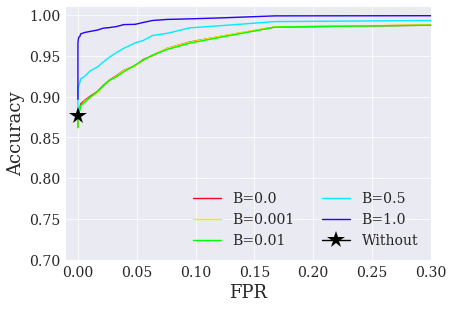

<Figure size 460.8x316.8 with 0 Axes>

In [67]:
mnist_lambda_003_beta_search = './../results/MNIST/mnist_lambda_003_beta_search'
mnist_lambda_003_no_attack = './../results/MNIST/mnist_lambda_003_no_attack'

natural_results_path_l, adaptive_results_path_l = analyze_utilities.create_list_of_corresponding_results_by_params(\
                                               mnist_lambda_003_no_attack, mnist_lambda_003_beta_search, paths_to_res_file_flag=False)
adaptive_results_path_l =[adaptive_results_path_l[0][-1]] + (adaptive_results_path_l[0][0:-2])[0::2] + [adaptive_results_path_l[0][-2]]

mnist_pgd_pgd_fgsm_all = ['./../results/paper/MNIST/mnist_adversarial_results_20190802_151544/results_mnist_adversarial_20190802_151544.json']  # [Original\PNML Accuracy] = [0.9051\0.9519]
_, baseline_df = analyze_utilities.load_results_to_df(mnist_pgd_pgd_fgsm_all, idx=range(0,3000))
print("baseline is {}".format(baseline_df.loc["acc", "erm"]))
fig_name = 'fig_adv_detector'
adv_risk_detector(natural_results_path_l, adaptive_results_path_l, None, None, idx=range(0,3000),\
                  baseline_df=baseline_df, fig_name=fig_name)

baseline is 0.8763333333333333
['./../results/MNIST/mnist_lambda_001_no_attack\\mnist_adversarial_results_20191017_123849']
Loading:['./../results/MNIST/mnist_lambda_001_no_attack\\mnist_adversarial_results_20191017_123849\\results_mnist_adversarial_20191017_123849.json']
3000
Loading:['./../results/MNIST/mnist_lambda_001_beta_search\\mnist_adversarial_results_20191016_170941\\results_mnist_adversarial_20191016_170941.json']
############ Lambda: 0.01 Beta: 0.005 ############
Natural: 0.968, PGD: nan, Adaptive: 0.8946666666666667, FPR: 0.014666666666666666 Risk: 0.078125
Natural: 0.975, PGD: nan, Adaptive: 0.8876666666666667, FPR: 0.004666666666666667 Risk: 0.09375
Natural: 0.976, PGD: nan, Adaptive: 0.883, FPR: 0.001 Risk: 0.109375
Natural: 0.976, PGD: nan, Adaptive: 0.8776666666666667, FPR: 0.0003333333333333333 Risk: 0.125
Natural: 0.976, PGD: nan, Adaptive: 0.8763333333333333, FPR: 0.0 Risk: 0.140625
Natural: 0.976, PGD: nan, Adaptive: 0.8743333333333333, FPR: 0.0 Risk: 0.15625
Natu

############ Lambda: 0.01 Beta: 0.7 ############
Natural: 0.968, PGD: nan, Adaptive: 0.896, FPR: 0.014666666666666666 Risk: 0.078125
Natural: 0.975, PGD: nan, Adaptive: 0.8923333333333333, FPR: 0.004666666666666667 Risk: 0.09375
Natural: 0.976, PGD: nan, Adaptive: 0.891, FPR: 0.001 Risk: 0.109375
Natural: 0.976, PGD: nan, Adaptive: 0.89, FPR: 0.0003333333333333333 Risk: 0.125
Natural: 0.976, PGD: nan, Adaptive: 0.8893333333333333, FPR: 0.0 Risk: 0.140625
Natural: 0.976, PGD: nan, Adaptive: 0.889, FPR: 0.0 Risk: 0.15625
Natural: 0.976, PGD: nan, Adaptive: 0.8886666666666667, FPR: 0.0 Risk: 0.171875
Natural: 0.976, PGD: nan, Adaptive: 0.8883333333333333, FPR: 0.0 Risk: 0.203125
Loading:['./../results/MNIST/mnist_lambda_001_beta_search\\mnist_adversarial_results_20191016_171001\\results_mnist_adversarial_20191016_171001.json']
############ Lambda: 0.01 Beta: 0.8 ############
Natural: 0.968, PGD: nan, Adaptive: 0.9036666666666666, FPR: 0.014666666666666666 Risk: 0.078125
Natural: 0.975, PG

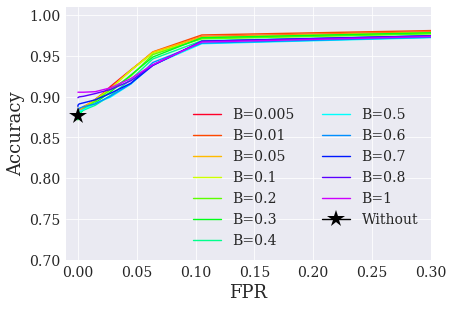

<Figure size 460.8x316.8 with 0 Axes>

In [68]:
mnist_lambda_001_beta_search = './../results/MNIST/mnist_lambda_001_beta_search'
mnist_lambda_001_no_attack = './../results/MNIST/mnist_lambda_001_no_attack'
idx = range(0, 3000)
# mnist_lambda_01_no_attack = './../results/MNIST/mnist_lambda_01_no_attack'   # [Original\PNML Accuracy] = [0.9832\0.9831]
# mnist_lambda_01_beta_search = './../results/MNIST/mnist_lambda_01_beta_search'
natural_results_path_l, adaptive_results_path_l = analyze_utilities.create_list_of_corresponding_results_by_params(\
                                               mnist_lambda_001_no_attack, mnist_lambda_001_beta_search, paths_to_res_file_flag=False)
# adaptive_results_path_l =[adaptive_results_path_l[0][-1]] + (adaptive_results_path_l[0][0:-2])[0::2] + [adaptive_results_path_l[0][-2]]
adaptive_results_path_l = adaptive_results_path_l[0]
mnist_pgd_pgd_fgsm_all = ['./../results/paper/MNIST/mnist_adversarial_results_20190802_151544/results_mnist_adversarial_20190802_151544.json']  # [Original\PNML Accuracy] = [0.9051\0.9519]
_, baseline_df = analyze_utilities.load_results_to_df(mnist_pgd_pgd_fgsm_all, idx=idx)
print("baseline is {}".format(baseline_df.loc["acc", "erm"]))
fig_name = 'fig_adv_detector_lambda_001'
adv_risk_detector(natural_results_path_l, adaptive_results_path_l, None, None, idx=idx, baseline_df=baseline_df, fig_name=fig_name)

No match in directory: ./../results/MNIST/mnist_eps_beta_search\mnist_adversarial_results_20191016_013113 for eps1: 0.08
length of natural_results_path_l: 7
baseline accuracy is 0.91
['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234628']
Loading:['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234628\\results_mnist_adversarial_20190916_234628.json']
200
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_170415\\results_mnist_adversarial_20191015_170415.json']
############ Lambda: 0.01 Beta: 0.0 ############
Natural: 0.985, PGD: nan, Adaptive: 0.97, FPR: 0.015 Risk: 0.046875
Natural: 0.99, PGD: nan, Adaptive: 0.955, FPR: 0.01 Risk: 0.0625
Natural: 0.995, PGD: nan, Adaptive: 0.93, FPR: 0.0 Risk: 0.078125
Natural: 0.995, PGD: nan, Adaptive: 0.92, FPR: 0.0 Risk: 0.09375
Natural: 0.995, PGD: nan, Adaptive: 0.91, FPR: 0.0 Risk: 0.109375
Loading:['./../results/MNIST/mnist_eps_beta_se

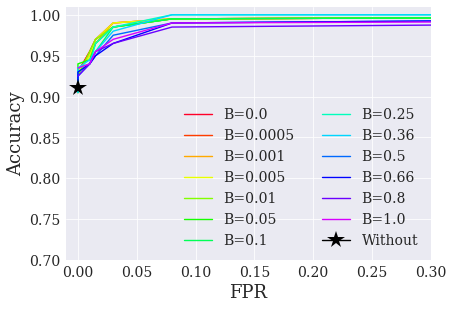

<Figure size 460.8x316.8 with 0 Axes>

['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234630']
Loading:['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234630\\results_mnist_adversarial_20190916_234630.json']
200
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_170953\\results_mnist_adversarial_20191015_170953.json']
############ Lambda: 0.02 Beta: 0.0 ############
Natural: 0.985, PGD: nan, Adaptive: 0.96, FPR: 0.015 Risk: 0.078125
Natural: 0.985, PGD: nan, Adaptive: 0.955, FPR: 0.015 Risk: 0.09375
Natural: 0.99, PGD: nan, Adaptive: 0.95, FPR: 0.01 Risk: 0.109375
Natural: 0.99, PGD: nan, Adaptive: 0.945, FPR: 0.005 Risk: 0.125
Natural: 0.995, PGD: nan, Adaptive: 0.935, FPR: 0.0 Risk: 0.140625
Natural: 0.995, PGD: nan, Adaptive: 0.93, FPR: 0.0 Risk: 0.15625
Natural: 0.995, PGD: nan, Adaptive: 0.92, FPR: 0.0 Risk: 0.171875
Natural: 0.995, PGD: nan, Adaptive: 0.915, FPR: 0.0 Risk: 0.21875
Natural: 0.995, PGD: nan, Ad

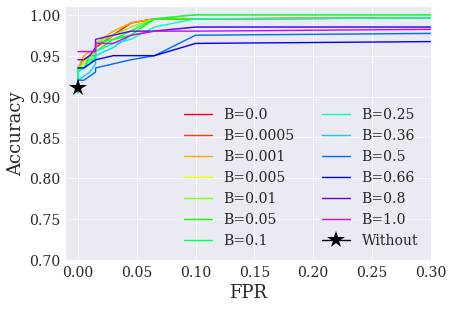

<Figure size 460.8x316.8 with 0 Axes>

['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234632']
Loading:['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234632\\results_mnist_adversarial_20190916_234632.json']
200
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_171535\\results_mnist_adversarial_20191015_171535.json']
############ Lambda: 0.03 Beta: 0.0 ############
Natural: 0.985, PGD: nan, Adaptive: 0.97, FPR: 0.015 Risk: 0.109375
Natural: 0.985, PGD: nan, Adaptive: 0.955, FPR: 0.015 Risk: 0.125
Natural: 0.99, PGD: nan, Adaptive: 0.95, FPR: 0.01 Risk: 0.140625
Natural: 0.99, PGD: nan, Adaptive: 0.94, FPR: 0.005 Risk: 0.171875
Natural: 0.995, PGD: nan, Adaptive: 0.93, FPR: 0.0 Risk: 0.25
Natural: 0.995, PGD: nan, Adaptive: 0.925, FPR: 0.0 Risk: 0.265625
Natural: 0.995, PGD: nan, Adaptive: 0.92, FPR: 0.0 Risk: 0.28125
Natural: 0.995, PGD: nan, Adaptive: 0.91, FPR: 0.0 Risk: 0.296875
Natural: 0.995, PGD: nan, Adapti

Natural: 0.99, PGD: nan, Adaptive: 0.95, FPR: 0.005 Risk: 0.15625
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191016_002453\\results_mnist_adversarial_20191016_002453.json']
############ Lambda: 0.03 Beta: 0.8 ############
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191016_010326\\results_mnist_adversarial_20191016_010326.json']
############ Lambda: 0.03 Beta: 1.0 ############
Natural: 0.99, PGD: nan, Adaptive: 0.965, FPR: 0.01 Risk: 0.140625


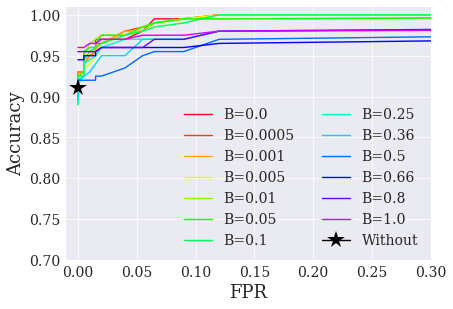

<Figure size 460.8x316.8 with 0 Axes>

['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234634']
Loading:['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234634\\results_mnist_adversarial_20190916_234634.json']
200
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_172114\\results_mnist_adversarial_20191015_172114.json']
############ Lambda: 0.04 Beta: 0.0 ############
Natural: 0.985, PGD: nan, Adaptive: 0.955, FPR: 0.015 Risk: 0.140625
Natural: 0.985, PGD: nan, Adaptive: 0.945, FPR: 0.015 Risk: 0.15625
Natural: 0.985, PGD: nan, Adaptive: 0.94, FPR: 0.015 Risk: 0.171875
Natural: 0.99, PGD: nan, Adaptive: 0.93, FPR: 0.005 Risk: 0.1875
Natural: 0.99, PGD: nan, Adaptive: 0.925, FPR: 0.005 Risk: 0.234375
Natural: 0.995, PGD: nan, Adaptive: 0.915, FPR: 0.0 Risk: 0.3125
Natural: 0.995, PGD: nan, Adaptive: 0.91, FPR: 0.0 Risk: 0.328125
Natural: 0.995, PGD: nan, Adaptive: 0.905, FPR: 0.0 Risk: 0.375
Natural: 0.995, PGD: nan, 

Natural: 0.985, PGD: nan, Adaptive: 0.93, FPR: 0.015 Risk: 0.171875
Natural: 0.99, PGD: nan, Adaptive: 0.92, FPR: 0.005 Risk: 0.203125
Natural: 0.99, PGD: nan, Adaptive: 0.915, FPR: 0.005 Risk: 0.234375
Natural: 0.99, PGD: nan, Adaptive: 0.91, FPR: 0.005 Risk: 0.25
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_235146\\results_mnist_adversarial_20191015_235146.json']
############ Lambda: 0.04 Beta: 0.66 ############
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191016_003022\\results_mnist_adversarial_20191016_003022.json']
############ Lambda: 0.04 Beta: 0.8 ############
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191016_010901\\results_mnist_adversarial_20191016_010901.json']
############ Lambda: 0.04 Beta: 1.0 ############


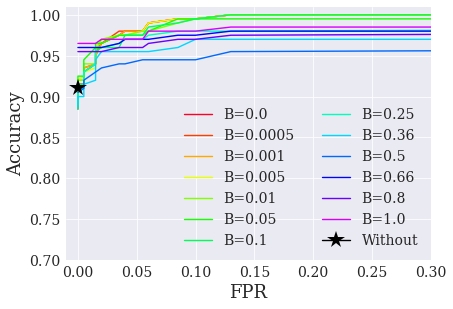

<Figure size 460.8x316.8 with 0 Axes>

['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234636']
Loading:['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234636\\results_mnist_adversarial_20190916_234636.json']
200
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_172653\\results_mnist_adversarial_20191015_172653.json']
############ Lambda: 0.05 Beta: 0.0 ############
Natural: 0.985, PGD: nan, Adaptive: 0.955, FPR: 0.015 Risk: 0.171875
Natural: 0.985, PGD: nan, Adaptive: 0.95, FPR: 0.015 Risk: 0.203125
Natural: 0.985, PGD: nan, Adaptive: 0.935, FPR: 0.01 Risk: 0.21875
Natural: 0.99, PGD: nan, Adaptive: 0.93, FPR: 0.005 Risk: 0.25
Natural: 0.99, PGD: nan, Adaptive: 0.92, FPR: 0.005 Risk: 0.265625
Natural: 0.99, PGD: nan, Adaptive: 0.915, FPR: 0.005 Risk: 0.3125
Natural: 0.995, PGD: nan, Adaptive: 0.905, FPR: 0.0 Risk: 0.328125
Natural: 0.995, PGD: nan, Adaptive: 0.9, FPR: 0.0 Risk: 0.34375
Natural: 0.995, PGD: nan, Ad

Natural: 0.995, PGD: nan, Adaptive: 0.89, FPR: 0.0 Risk: 0.375
Natural: 0.995, PGD: nan, Adaptive: 0.885, FPR: 0.0 Risk: 0.421875
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_231833\\results_mnist_adversarial_20191015_231833.json']
############ Lambda: 0.05 Beta: 0.5 ############
Natural: 0.985, PGD: nan, Adaptive: 0.945, FPR: 0.015 Risk: 0.15625
Natural: 0.985, PGD: nan, Adaptive: 0.94, FPR: 0.015 Risk: 0.203125
Natural: 0.985, PGD: nan, Adaptive: 0.935, FPR: 0.01 Risk: 0.21875
Natural: 0.99, PGD: nan, Adaptive: 0.92, FPR: 0.005 Risk: 0.234375
Natural: 0.99, PGD: nan, Adaptive: 0.91, FPR: 0.005 Risk: 0.28125
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_235721\\results_mnist_adversarial_20191015_235721.json']
############ Lambda: 0.05 Beta: 0.66 ############
Natural: 0.985, PGD: nan, Adaptive: 0.97, FPR: 0.015 Risk: 0.1875
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_201

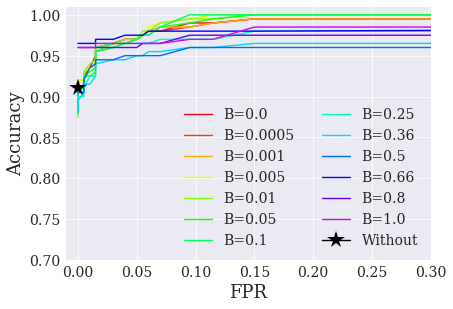

<Figure size 460.8x316.8 with 0 Axes>

['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234638']
Loading:['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234638\\results_mnist_adversarial_20190916_234638.json']
200
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_173227\\results_mnist_adversarial_20191015_173227.json']
############ Lambda: 0.06 Beta: 0.0 ############
Natural: 0.985, PGD: nan, Adaptive: 0.95, FPR: 0.015 Risk: 0.203125
Natural: 0.985, PGD: nan, Adaptive: 0.94, FPR: 0.015 Risk: 0.21875
Natural: 0.985, PGD: nan, Adaptive: 0.935, FPR: 0.015 Risk: 0.234375
Natural: 0.985, PGD: nan, Adaptive: 0.93, FPR: 0.01 Risk: 0.25
Natural: 0.99, PGD: nan, Adaptive: 0.92, FPR: 0.005 Risk: 0.265625
Natural: 0.995, PGD: nan, Adaptive: 0.905, FPR: 0.0 Risk: 0.390625
Natural: 0.995, PGD: nan, Adaptive: 0.9, FPR: 0.0 Risk: 0.453125
Natural: 0.995, PGD: nan, Adaptive: 0.89, FPR: 0.0 Risk: 0.46875
Natural: 0.995, PGD: nan, Ad

Natural: 0.995, PGD: nan, Adaptive: 0.865, FPR: 0.0 Risk: 0.421875
Natural: 0.995, PGD: nan, Adaptive: 0.86, FPR: 0.0 Risk: 0.453125
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_232406\\results_mnist_adversarial_20191015_232406.json']
############ Lambda: 0.06 Beta: 0.5 ############
Natural: 0.985, PGD: nan, Adaptive: 0.915, FPR: 0.015 Risk: 0.21875
Natural: 0.99, PGD: nan, Adaptive: 0.91, FPR: 0.005 Risk: 0.328125
Natural: 0.99, PGD: nan, Adaptive: 0.9, FPR: 0.005 Risk: 0.34375
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191016_000255\\results_mnist_adversarial_20191016_000255.json']
############ Lambda: 0.06 Beta: 0.66 ############
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191016_004118\\results_mnist_adversarial_20191016_004118.json']
############ Lambda: 0.06 Beta: 0.8 ############
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191016_

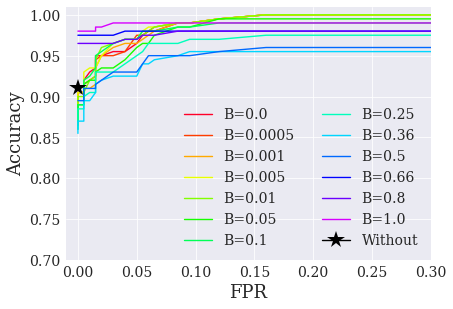

<Figure size 460.8x316.8 with 0 Axes>

['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234640']
Loading:['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234640\\results_mnist_adversarial_20190916_234640.json']
200
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_173803\\results_mnist_adversarial_20191015_173803.json']
############ Lambda: 0.07 Beta: 0.0 ############
Natural: 0.985, PGD: nan, Adaptive: 0.96, FPR: 0.015 Risk: 0.203125
Natural: 0.985, PGD: nan, Adaptive: 0.955, FPR: 0.015 Risk: 0.21875
Natural: 0.985, PGD: nan, Adaptive: 0.95, FPR: 0.015 Risk: 0.234375
Natural: 0.99, PGD: nan, Adaptive: 0.945, FPR: 0.005 Risk: 0.296875
Natural: 0.99, PGD: nan, Adaptive: 0.94, FPR: 0.005 Risk: 0.3125
Natural: 0.99, PGD: nan, Adaptive: 0.935, FPR: 0.005 Risk: 0.328125
Natural: 0.99, PGD: nan, Adaptive: 0.93, FPR: 0.005 Risk: 0.34375
Natural: 0.99, PGD: nan, Adaptive: 0.925, FPR: 0.005 Risk: 0.359375
Natural: 0.99, PGD: 

Natural: 0.995, PGD: nan, Adaptive: 0.88, FPR: 0.0 Risk: 0.453125
Natural: 0.995, PGD: nan, Adaptive: 0.875, FPR: 0.0 Risk: 0.546875
Natural: 0.995, PGD: nan, Adaptive: 0.87, FPR: 0.0 Risk: 0.578125
Natural: 0.995, PGD: nan, Adaptive: 0.865, FPR: 0.0 Risk: 0.625
Natural: 0.995, PGD: nan, Adaptive: 0.86, FPR: 0.0 Risk: 0.75
Loading:['./../results/MNIST/mnist_eps_beta_search\\mnist_adversarial_results_20191015_221220\\results_mnist_adversarial_20191015_221220.json']
############ Lambda: 0.07 Beta: 0.25 ############
Natural: 0.985, PGD: nan, Adaptive: 0.905, FPR: 0.015 Risk: 0.203125
Natural: 0.985, PGD: nan, Adaptive: 0.895, FPR: 0.015 Risk: 0.21875
Natural: 0.99, PGD: nan, Adaptive: 0.89, FPR: 0.005 Risk: 0.296875
Natural: 0.99, PGD: nan, Adaptive: 0.885, FPR: 0.005 Risk: 0.3125
Natural: 0.99, PGD: nan, Adaptive: 0.88, FPR: 0.005 Risk: 0.375
Natural: 0.995, PGD: nan, Adaptive: 0.875, FPR: 0.0 Risk: 0.453125
Natural: 0.995, PGD: nan, Adaptive: 0.87, FPR: 0.0 Risk: 0.546875
Natural: 0.995

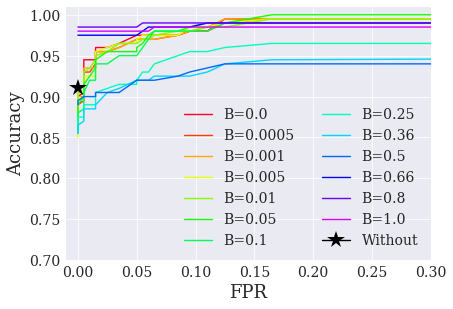

<Figure size 460.8x316.8 with 0 Axes>

Done


In [45]:
idx = range(0,200)

mnist_lambda_beta_search = './../results/MNIST/mnist_eps_beta_search' # 200 samples, refinement 0.01-0.07 (0.08 didn't work) with beta=[0 1]
mnist_pgd_natural_diff_refinement = './../results/MNIST/mnist_param_search_noattack'
# mnist_pgd_detectorAdaptive_lambda_beta_search = './../results/MNIST/adaptive_lambda_beta_search'

natural_results_path_l, det_adaptive_results_path_l = analyze_utilities.create_list_of_corresponding_results_by_params(\
                                  mnist_pgd_natural_diff_refinement, mnist_lambda_beta_search, paths_to_res_file_flag=False)
# natural_results_path_l, adaptive_results_path_l = analyze_utilities.create_list_of_corresponding_results_by_params(\
#                                                mnist_pgd_natural_diff_refinement, mnist_pgd_adaptive_diff_refinement, paths_to_res_file_flag=False)
print("length of natural_results_path_l: {}".format(len(natural_results_path_l)))
_, baseline_df = analyze_utilities.load_results_to_df(mnist_pgd_pgd_fgsm_all, idx=idx)
print("baseline accuracy is {}".format(baseline_df.loc["acc", "erm"]))

for i, natural_results_path in enumerate(natural_results_path_l):
    adv_risk_detector([natural_results_path], det_adaptive_results_path_l[i], idx=idx, baseline_df=baseline_df)
    
print("Done")